In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import (LinearRegression,Ridge,Lasso,ElasticNet)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_absolute_error,mean_squared_error,r2_score)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV


In [ ]:
featureMatrix = pd.read_csv('/content/drive/MyDrive/ml_project/final_feature_matrix.csv')

In [ ]:
featureMatrix.shape
featureMatrix.head()

,user_id,product_id,user_product_purchase_count,user_product_reorder_ratio,user_product_days_since_last_purchase,user_total_orders,user_reorder_ratio,user_avg_basket_size,user_mean_days_between_orders,user_days_since_last_order,log_user_total_orders
0,1,196,10,0.900000,19.0,10,0.694915,5.9,20.25926,19.0,2.397895
1,1,10258,9,0.888889,19.0,10,0.694915,5.9,20.25926,19.0,2.397895
2,1,10326,1,0.000000,28.0,10,0.694915,5.9,20.25926,19.0,2.397895
3,1,12427,10,0.900000,19.0,10,0.694915,5.9,20.25926,19.0,2.397895
4,1,13032,3,0.666667,30.0,10,0.694915,5.9,20.25926,19.0,2.397895


This step loads the final dataset and checks that it is ready for modeling.

In [ ]:
orders = pd.read_csv('/content/drive/MyDrive/ml_project/orders.csv')

In [ ]:
orders_sorted = orders.sort_values(['user_id', 'order_number'])
last_orders = orders_sorted.groupby('user_id').tail(1)

In [ ]:
data = featureMatrix.merge(last_orders[['user_id', 'days_since_prior_order']],on='user_id',how='inner')

In [ ]:
data = data.sort_values("user_days_since_last_order", ascending=False)

In [ ]:
data = data.sort_values("user_days_since_last_order", ascending=False)

split_idx = int(len(data) * 0.8)
train_data = data.iloc[:split_idx]
test_data  = data.iloc[split_idx:]

In [ ]:
X_train = train_data.drop(columns=['days_since_prior_order', 'user_id'])
y_train = train_data['days_since_prior_order']
X_test  = test_data.drop(columns=['days_since_prior_order', 'user_id'])
y_test  = test_data['days_since_prior_order']

In [ ]:
X_train = X_train.fillna(X_train.median())
X_test  = X_test.fillna(X_train.median())

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

LinearRegression()

In [ ]:
y_pred_lr = linear_model.predict(X_test_scaled)

In [ ]:
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print("Linear Regression Performance:")
print(f"MAE:  {mae_lr:.4f}")
print(f"MSE:  {mse_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")
print(f"R²:   {r2_lr:.4f}")

Linear Regression Performance:
MAE:  6.1546
MSE:  65.3507
RMSE: 8.0840
R²:   0.2460


A Random Forest Regressor is used to capture non-linear relationships
and feature interactions. Initial hyperparameters are set to control
model complexity and reduce overfitting. Hyperparameter tuning is
performed in a later step.


In [ ]:
rf_model = RandomForestRegressor(n_estimators=100,max_depth=5,max_samples=0.8,min_samples_leaf=10,random_state=42,n_jobs=-1)

A Random Forest Regressor is trained to capture non-linear relationships
and feature interactions in the data.

In [ ]:
# Train the Random Forest model
rf_model.fit(X_train, y_train)
# Predict on the test set
y_pred_rf = rf_model.predict(X_test)
# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest Regression Performance:")
print(f"MAE:  {mae_rf:.4f}")
print(f"MSE:  {mse_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²:   {r2_rf:.4f}")

Random Forest Regression Performance:
MAE:  6.0488
MSE:  63.7449
RMSE: 7.9840
R²:   0.2645


In [ ]:
residuals_lr = y_test - y_pred_lr

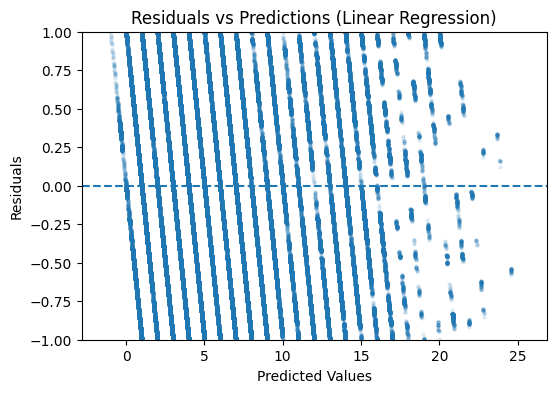

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(y_pred_lr, residuals_lr, alpha=0.1, s=5)
plt.axhline(0, linestyle='--')
plt.ylim(-1, 1)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions (Linear Regression)")
plt.show()

The residual plot shows a concentration of errors around zero with a visible
pattern, indicating limitations of the linear model in capturing the
underlying non-linear structure of the data.

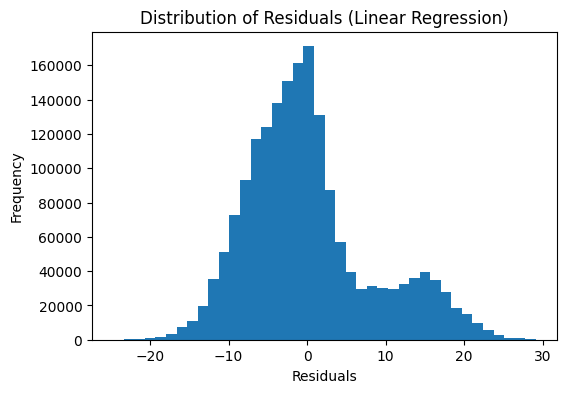

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(residuals_lr, bins=40)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Linear Regression)")
plt.show()

The histogram of residuals shows a concentration around zero with slight
skewness, which is expected given the bounded target variable.

In [ ]:
results = pd.DataFrame({
    "Model": ["Linear Regression","Random Forest"],
    "MAE": [mae_lr, mae_rf],
    "RMSE": [rmse_lr, rmse_rf],
    "R2": [r2_lr, r2_rf]})
results

,Model,MAE,RMSE,R2
0,Linear Regression,6.154622,8.083977,0.246023
1,Random Forest,6.048771,7.984042,0.264549


In [ ]:
results.sort_values("RMSE")

,Model,MAE,RMSE,R2
1,Random Forest,6.048771,7.984042,0.264549
0,Linear Regression,6.154622,8.083977,0.246023


The comparison results indicate that the Random Forest regressor achieves
lower error metrics and higher R² compared to the linear baseline, suggesting
that non-linear models are more suitable for capturing user–product behavior.

In [ ]:
lasso_model = Lasso(alpha=0.001,max_iter=10000)

In [ ]:
lasso_model.fit(X_train_scaled, y_train)

Lasso(alpha=0.001, max_iter=10000)

In [ ]:
y_pred_lasso = lasso_model.predict(X_test_scaled)

In [ ]:
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)
mae_lasso, rmse_lasso, r2_lasso

(6.154815562021917, np.float64(8.083848028948216), 0.24604710553143494)

In [ ]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Lasso", "Random Forest"],
    "MAE": [mae_lr, mae_lasso, mae_rf],
    "RMSE": [rmse_lr, rmse_lasso, rmse_rf],
    "R2": [r2_lr, r2_lasso, r2_rf]})
results

,Model,MAE,RMSE,R2
0,Linear Regression,6.154622,8.083977,0.246023
1,Lasso,6.154816,8.083848,0.246047
2,Random Forest,6.048771,7.984042,0.264549


In [ ]:
results = results.sort_values("RMSE")

Lasso regression was included as a regularized linear model to control overfitting. While it provides improved stability compared to the baseline linear regression, the Random Forest model achieves the best overall performance.